### Two-sample t-test and robustness
**Posted on 11 May 2018 by John**
source:
https://www.johndcook.com/blog/2018/05/11/two-sample-t-test/ site visited on 28.05.2020

This notebook conists the explanations and code samples from John D. Cook shown on his blog expanded with some interactivity. One can play with different settings and explore the effect when one of the distributions is not symmetric. 
Thus, the questions in the post "...How far can you be from a normal distribution and still do OK? Can you have any distribution as long as it’s symmetric? Does a little asymmetry ruin everything? If something does go wrong, how does it go wrong?" can be explored interactivly.

Overview interactive controls:
- distribution paramerters (µ, $\sigma$)
- sample size
- number of t-tests
- number of randomly picked numbers

Overview of scipy.stats functions:
- normal distribution: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html#scipy.stats.norm
- gamma distribution: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gamma.html#scipy.stats.gamma
- t-test : https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html#scipy.stats.ttest_ind


In [1]:
# interaktive controls
#
import numpy as np
from scipy.stats import norm, t, gamma, uniform, ttest_ind
import matplotlib.pyplot as plt
import ipywidgets as widgets

%matplotlib nbagg

#
#
style = {'description_width': 'initial'}
#
SldSampleSize = widgets.IntSlider(min=50, max=5000, value=1000, description="sample size", style=style, continious_update=False)
ITXTNTrials = widgets.IntText(min=1, max= 5000, value=1000, description="number of trials", style=style, continuous_update=False, layout = {'width': '20%'})
ITXTNPerGroup = widgets.IntText(min=1, max=5000, value=36, description="number per group",  style=style, continuous_update=False, layout = {'width': '20%'})
#
TGBTNDistr1 = widgets.ToggleButtons(
    options=['gauss', ''],
    description='',
    disabled=False,
    button_style='', 
    tooltips=['Normal distribution', ''],
)
distrib_1 = widgets.VBox(
    [
        widgets.Label(value="1st distribution:"),
        TGBTNDistr1
    ]
)
#
TGBTNDistr2 = widgets.ToggleButtons(
    options=['gauss', 'gamma'],
    description='',
    disabled=False,
    button_style='', 
    tooltips=['Normal distribution', 'Gamma distribution'],
)
distrib_2 = widgets.VBox(
    [
        widgets.Label(value="2nd distribution:"),
        TGBTNDistr2
    ]
)
#
# Erwartungswert und Standrdabweichung der Standardverteilung
#
SldMean1 = widgets.FloatSlider(min=-50, max=150, value=100.0, description="", continuous_update=False)
SldSig1 = widgets.FloatSlider(min=0.1, max=50, value=15, description='', continuous_update=False)
#
set1 = widgets.VBox(
    [
        widgets.Label(value="$µ_1$ (mean value):"),
        SldMean1,
        widgets.Label(value="$\sigma_2$ (standard deviation):"),
        SldSig1
        ]
)
#
SldMean2 = widgets.FloatSlider(min=-50, max=150, value=100.0, description="", continuous_update=False)
SldSig2 = widgets.FloatSlider(min=0.1, max=50, value=15, description='', continuous_update=False)
SldShift = widgets.IntSlider(min= 0, max=200, value=90, continuous_update=False)
#
set2 = widgets.VBox(
    [
        widgets.Label(value="$µ_2$ (mean value):"),
        SldMean2,
        widgets.Label(value="$\sigma_2$ (standard deviation):"),
        SldSig2,
        widgets.Label(value="shift parameter for gamma distribution"),
        SldShift
])
#
# diagram range selectors
xRange = widgets.IntRangeSlider(min=-20, max=250, value=[40,140], description = "diagram x-range", style = style)
# yRange = widgets.IntRangeSlider(min=0, max=20, value=[0, 0.03], step=0.01, description = "diagram y-range", style = style)
# buttons
# 
BtnReload = widgets.Button(description="test",button_style='info', tooltip="do an independent 2-sample t-test of the 2 distributions")
BtnReset = widgets.Button(description="Reset", button_style='warning', tooltip="reset to default values")
#

In [2]:
# simulate_trials:
# according to : https://www.johndcook.com/blog/2018/05/11/two-sample-t-test/ site visited on 28.05.2020
# 
#
# two-sample t-test with a certain amount of values of each group
# 
#
# parameter_in:  num_trials:  number of repetitions
#                numPerGroup: number of random values selected for the test
#                group1:      distribution 1
#                group2:      distribution 2
#
# parameter_out: num_rejects: number of tests rejecting the null hypothesis
#
def simulate_trials(num_trials, numPerGroup, group1, group2):
    num_reject = 0
    for _ in range(num_trials):
        a = group1.rvs(numPerGroup)
        b = group2.rvs(numPerGroup)
        stat, pvalue = ttest_ind(a, b)
        if pvalue < 0.05:
            num_reject += 1
    return(num_reject)

In [3]:
# initialize global variables
#
nSampleOld = 0
mu1Old = 0
sig1Old = 0
mu2Old = 0
sig2Old = 0
n1 = 0
n2 = 0
x1 = 0
x2 = 0
rejects = 0
dist2_old = ''
#

In [31]:
# plot function
#
def plot_diagrams(dictDistributions, ax):
    ax.clear()
    x1 = dictDistributions['x1']
    ax.plot(x1, dictDistributions['n1'].pdf(x1), color='C1')
    #
    x2 = dictDistributions['x2']
    ax.plot(x2, dictDistributions['n2'].pdf(x2), color = 'blue')
    #
    # get informations about mean and rejects due to two-sample t.test
    #
    textstr = '\n'.join((\
                         "Parameter der Normalverteilung",
                         r'$\mathrm{µ_1}=%.2f$' % (dictDistributions['mu1'], ),
                         r'$\mathrm{\sigma_1}=%.2f$' % (dictDistributions['sig1'], ),
                         r'$\mathrm{µ_2}=%.2f$' % (dictDistributions['mu2'], ),
                         r'$\mathrm{\sigma_2}=%.2f$' % (dictDistributions['sig2'], ),
                         r'number of rejects: %3d' % (dictDistributions['rejects'], ),
                         'ratio: {:.2f}%'.format(dictDistributions['rate'], ),
                        ))
    props = dict(boxstyle='round', facecolor='palegreen', alpha=0.5)
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox=props)
    #
    ax.set_xlim(xRange.value[0], xRange.value[-1])
#     ax.set_ylim(yRange.value[0], yRange.value[-1])
    ax.set_facecolor('lightcyan')
#

In [32]:
# callback function when button 'BtnReset' was pressed
#
def reset(*args):
    set1.children[1].value = 100         # µ_1
    set1.children[3].value = 15          # \sigma_1
    set2.children[1].value = 100         # µ_2
    set2.children[3].value = 15          # \sigma_2
    #
    distrib_1.children[1].value = 'gauss' # toggle-button_1
    distrib_2.children[1].value = 'gauss' # toggle_button_2
    #
    xRange.value = [40,140]
    SldSampleSize.value = 1000
    ITXTNTrials.value = 1000
    ITXTNTrials.value = 36
    #
    update_controls(True)
#

In [33]:
# callback function when button 'BtnReload' was pressed
#
def do_test(*args):
    update_controls("do test")

In [34]:
def update_controls(*args):
    #
    global nSampleOld, mu1Old, sig1Old, mu2Old, sig2Old, n1, n2, x1, x2, rejects, dist2_old, ax1
    #
    #
    dist1 = distrib_1.children[1].value
    dist2 = distrib_2.children[1].value
    #
    # presets for distribution 2
    #
    signalChange = False
    #
    # normal distribution:
    if (dist2 == 'gauss') and (dist2_old != dist2):
        set2.children[1].value = 100
        set2.children[3].value = 15
        set2.children[5].disabled = True
        signalChange = True
    #
    # gamma distribution:
    if (dist2 == 'gamma') and (dist2_old != dist2):
        set2.children[1].value = 10
        set2.children[3].value = 3.87
        set2.children[5].disabled = False
        set2.children[5].value = 90
        distrib_2.children[0].value = "shape parameter a: {} (mu/sigma)**2".format(set1.children[1].value)
        distrib_2.children[0].value = "scale parameter b: {} sigma**2/mu".format(set2.children[3].value)
        signalChange = True
    #
    #
    # just recalc distributions if parameters changed or BtnReload was pressed
    #
    mu1 = SldMean1.value
    sig1 = SldSig1.value
    mu2 = SldMean2.value
    sig2 = SldSig2.value
    shift = SldShift.value
    nSize = SldSampleSize.value
    nTrials = ITXTNTrials.value
    #
    reCalc = True
    if (nSampleOld != nSize) or (mu1Old != mu1) or (sig1Old != sig1) or (mu2Old != mu2) or (sig2Old != sig2):
        reCalc = False
    #
    if reCalc or signalChange:
        #
        # 1st distribution
        n1 = norm(mu1, sig1)
        x1 = np.arange(n1.ppf(0.01), n1.ppf(0.99), 1/500)
        #
        # 2nd distribution
        if dist2 == 'gauss':
            n2 = norm(mu2, sig2)
            x2 = np.arange(n2.ppf(0.01), n2.ppf(0.99), 1/500)
        if dist2 == 'gamma':
            #
            # clc mu to a(shape) and sigma to b(scale)
            # a = (mu/sigma)**2
            # b = sigma**2/mu
            # 
            a = (mu2 / sig2) ** 2
            b = (sig2**2) / mu2
            n2 = gamma(a = a, scale=b, loc=shift)
            x2 = np.arange(n2.ppf(0.01), n2.ppf(0.99), 1/500)
            mu2 = a
            sig2 = b
            mu2Old = a
            sig2Old = b
        #
        rejects = simulate_trials(nTrials, ITXTNPerGroup.value, n1, n2)
    #
    # do t-test when button 'test' was pressed
    #
    if args[0] == "do test":
        rejects = simulate_trials(nTrials, ITXTNPerGroup.value, n1, n2)
    #
    #
    dictPlot = {
            'x1': x1,
            'n1': n1,
            'mu1': mu1,
            'sig1': sig1,
            'x2': x2,
            'n2': n2,
            'mu2': mu2,
            'sig2': sig2,
            'rejects': rejects,
            'rate': rejects / nTrials * 100
        }
    #
    plot_diagrams(dictPlot, ax1)
    #
    nSampleOld = SldSampleSize.value
    mu1Old = SldMean1.value
    sig1Old = SldSig1.value
    mu2Old = SldMean2.value
    sig2Old = SldSig2.value
    dist2_old = distrib_2.children[1].value
    #
#
SldSampleSize.observe(update_controls, 'value')
ITXTNTrials.observe(update_controls, 'value')
ITXTNPerGroup.observe(update_controls, 'value')
SldMean1.observe(update_controls, 'value')
SldMean2.observe(update_controls, 'value')
SldSig1.observe(update_controls, 'value')
SldSig2.observe(update_controls, 'value')
SldShift.observe(update_controls, 'value')
TGBTNDistr1.observe(update_controls, 'value')
TGBTNDistr2.observe(update_controls, 'value')
xRange.observe(update_controls, 'value')
# yRange.observe(update_controls, 'value')
BtnReload.on_click(do_test)


<IPython.core.display.Javascript object>


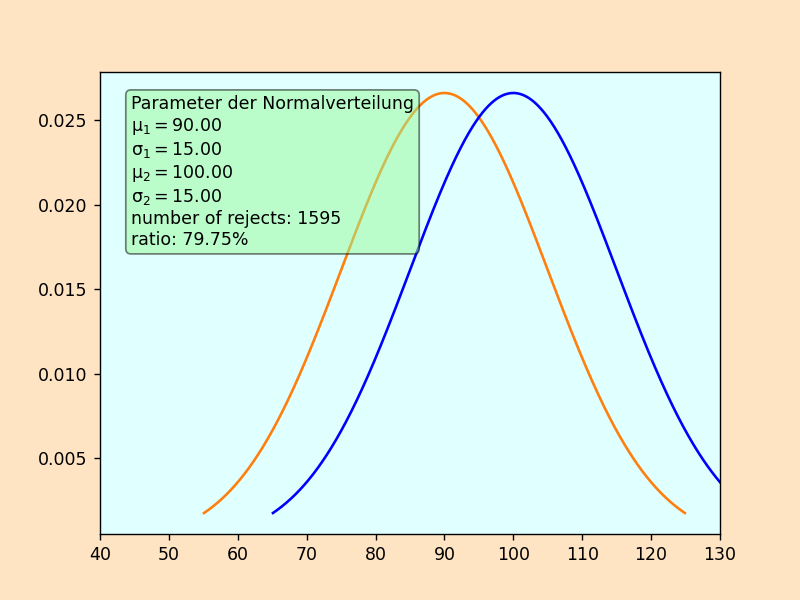

In [37]:
# interactive controls and diagram
#
# controls for distribution parameters
#
# diagram:
#  - prob. density function of both distributions
#  - mean-values, number of rejected hypotheses
#
fig1, ax1 = plt.subplots(facecolor='bisque')
#
#
# arange controls
intWidgets = widgets.VBox([
    widgets.HBox([\
                  SldSampleSize,
                  ITXTNTrials,
                  ITXTNPerGroup,
                  BtnReload,
                  BtnReset
                 ]),
    widgets.HTML(value="<hr>"),
    widgets.HBox([\
                  widgets.VBox([\
                                distrib_1,
                                set1
                               ]),
                  widgets.HTML(value="<div>"),
                  widgets.VBox([\
                                distrib_2,
                                set2,
                               ]),
                  xRange
                      ]),
    widgets.HTML(value="<hr>"),
#     yRange
])
#
# draw diagram for the 1st time with default settings
update_controls(True)
#
intWidgets

In [36]:
ax1.set_facecolor('azure')